This notebook models wildfire data with NB and SVC supervised mode
Code adapted from group member Juhee Sung-Schenck

In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# read in csv

df = pd.read_csv('../data/final.csv')

print(df.shape)
df.head()

(19999, 9)


,id,user_name,lat,long,date,text,text_clean,n_sentence,n_words
0,1305657570774978560,FireandAviation,37.280386,-122.128109,2020-09-14 23:59:57+00:00,Smoke from California wildfires causes hazy sk...,smoke from california wildfire cause hazy sky ...,1,9
1,1304359517552095235,JoinDeepRock,36.052556,-119.406770,2020-09-11 10:01:57+00:00,96% Overwhelmingly Positive Reviews! Grab a fr...,overwhelmingly positive review grab a frien...,2,15
2,1305657551703412736,matthew_paul17,35.839572,-122.243498,2020-09-14 23:59:52+00:00,So a 2-3 degree temperature difference is what...,so a degree temperature difference is what c...,1,36
3,1305657540227850240,Josie95450522,34.897778,-119.722077,2020-09-14 23:59:50+00:00,@POTUS is right about the #wildfires Expert in...,potus is right about the wildfires expert inve...,2,39
4,1305657538281533440,Arqahn,38.370841,-120.107434,2020-09-14 23:59:49+00:00,Wildfires in California ARE caused by poor lan...,wildfire in california are caused by poor land...,1,9


In [3]:
# check null values

df.isnull().sum()

id            0
user_name     0
lat           0
long          0
date          0
text          0
text_clean    0
n_sentence    0
n_words       0
dtype: int64

In [4]:
# about 3 percent of cleaned text are missing
# it could be due to non-english tweets that I did not know how to process in cleaning stage 
# will drop these rows

df.dropna(axis = 0, inplace = True)

In [5]:
## make your own relevant words here
# make a list of words that would automatically tag a word as relevant

relevant_words = ['wildfire']

In [6]:
# create a function to create a list of 1s and 0s

def create_target(column):    
    
    labels = []
    
    # separate each row
    for text in column:
        
        # initiate 0 as label
        label = 0
        
        # iterate through words in relevant_words
        for relevant_word in relevant_words:
            
            # if relevant_word is found in text, assign 1 as label
            # stop comparing once assigned as 1, then append it to the list
            if relevant_word in text:
                label = 1
                break
        labels.append(label)
        
    return labels

In [7]:
# check if the label is created as expected (if about 50%, then it's good!)

np.mean(create_target(df['text_clean']))

0.4705235261763088

In [8]:
# assign a column in the dataframe to capture this information

df['label'] = create_target(df['text_clean'])

In [9]:
df.head()

,id,user_name,lat,long,date,text,text_clean,n_sentence,n_words,label
0,1305657570774978560,FireandAviation,37.280386,-122.128109,2020-09-14 23:59:57+00:00,Smoke from California wildfires causes hazy sk...,smoke from california wildfire cause hazy sky ...,1,9,1
1,1304359517552095235,JoinDeepRock,36.052556,-119.406770,2020-09-11 10:01:57+00:00,96% Overwhelmingly Positive Reviews! Grab a fr...,overwhelmingly positive review grab a frien...,2,15,0
2,1305657551703412736,matthew_paul17,35.839572,-122.243498,2020-09-14 23:59:52+00:00,So a 2-3 degree temperature difference is what...,so a degree temperature difference is what c...,1,36,1
3,1305657540227850240,Josie95450522,34.897778,-119.722077,2020-09-14 23:59:50+00:00,@POTUS is right about the #wildfires Expert in...,potus is right about the wildfires expert inve...,2,39,1
4,1305657538281533440,Arqahn,38.370841,-120.107434,2020-09-14 23:59:49+00:00,Wildfires in California ARE caused by poor lan...,wildfire in california are caused by poor land...,1,9,1


In [10]:
# save this to a csv file

df.to_csv('../data/final_labeled.csv')

In [11]:
# define baseline accuracy

df['label'].value_counts(normalize = True)

0    0.529476
1    0.470524
Name: label, dtype: float64

## Modeling

In [12]:
# set up X and y and train test split

X = df['text_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42, stratify = y)

In [13]:
# create a custom stop words list

print(len(stopwords.words('english')))

stop_words = stopwords.words('english') + relevant_words

print(len(stop_words))

179
180


### CountVectorizer()
#### Multinomial Naive Bayes and Support Vector Machine

In [14]:
# set 2 pipelines with: 1. Multinomial Bayes 2. Support Vector Machine

pipeline_mb = Pipeline([
                       ('cvec', CountVectorizer()),
                       ('mb', MultinomialNB())
                       ])

pipeline_svc = Pipeline([
                        ('cvec', CountVectorizer()),
                        ('svc', SVC())
                        ])

In [15]:
# set up a dictionary to store the best parameters

model_mb_params = {}
count_mb = 0

model_svc_params = {}
count_svc = 0

In [16]:
# set up parameters

pipe_params = {
    'cvec__max_features': [3000, 4000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.85, .90],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [stop_words]
}

In [17]:
# instantiate GridSearchCV - NaiveBayes

gs_mb = GridSearchCV(pipeline_mb, 
                     param_grid = pipe_params, 
                     cv = 3) 

# instantiate GridSearchCV - SVC

gs_svc = GridSearchCV(pipeline_svc, 
                      param_grid = pipe_params, 
                      cv = 3) 

In [18]:
# increase counter as we put in different parameters

count_mb += 1

# fit the training set

gs_mb.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_mb.best_params_['score'] = gs_mb.best_score_

model_mb_params[f'model_{count_mb}'] = gs_mb.best_params_

# dictionary to a dataframe

model_mb_df = pd.DataFrame.from_dict(model_mb_params, orient = 'index')

In [19]:
model_mb_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,score
model_1,0.85,4000,2,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",0.919098


In [20]:
# increase counter as we put in different parameters

count_svc += 1

# fit the training set

gs_svc.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_svc.best_params_['score'] = gs_svc.best_score_

model_svc_params[f'model_{count_svc}'] = gs_svc.best_params_

# dictionary to a dataframe

model_svc_df = pd.DataFrame.from_dict(model_svc_params, orient = 'index')

In [21]:
model_svc_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,score
model_1,0.85,4000,3,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",0.936712


In [22]:
# train set score

print(f'Multinomial Naive Bayes: {gs_mb.score(X_train, y_train)}')
print(f'\nSVC: {gs_svc.score(X_train, y_train)}')

Multinomial Naive Bayes: 0.935144413762221

SVC: 0.9761922531532203


In [23]:
# test set score

print(f'Multinomial Naive Bayes: {gs_mb.score(X_test, y_test)}')
print(f'\nSVC: {gs_svc.score(X_test, y_test)}')

Multinomial Naive Bayes: 0.9177272727272727

SVC: 0.9407575757575758


In [24]:
# find the best parameters for both models

print(f'Multinomial Naive Bayes: \n{gs_mb.best_params_}')
print(f'\nSVC: \n{gs_svc.best_params_}')

Multinomial Naive Bayes: 
{'cvec__max_df': 0.85, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why'

In [25]:
# find the best estimators for both models

print(f'Multinomial Naive Bayes: \n{gs_mb.best_estimator_}')
print(f'\nSVC: \n{gs_svc.best_estimator_}')

Multinomial Naive Bayes: 
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=4000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mb', MultinomialNB())])

SVC: 
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=4000, min_df=3,
                                 ngram_range=(1, 2

In [34]:
# predictions for Naive Bayes

y_preds = gs_mb.predict(X_test)

# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [35]:
spec = tn / (tn + fp)
sens = tp /(tp + fn)
acc = (tp + tn)/(tn + fp + fn + tp)
prec = tp / (tp + fp)

print('Accuracy:', acc)
print('Specificity:', spec)
print('Sensitivity:', sens)
print('Precision', prec)

Accuracy: 0.9177272727272727
Specificity: 0.936480686695279
Sensitivity: 0.8966183574879227
Precision 0.9261477045908184


In [26]:
# predictions for svc

y_preds = gs_svc.predict(X_test)

# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

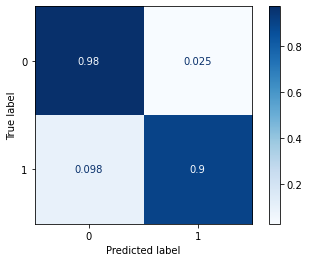

In [27]:
# view confusion matrix

plot_confusion_matrix(gs_svc, X_test, y_test, cmap = 'Blues', normalize = 'true');